Loading images...
Cropping PCB regions...
  Cropped from (4032, 3024, 3) to (2337, 2340, 3)
  Cropped from (4032, 3024, 3) to (2474, 2168, 3)
Aligning orientation...
Trying different orientations...
  0°: MSE = 3304.01
  90°: MSE = 3304.01
  180°: MSE = 3320.12
  270°: MSE = 2926.18
Best orientation: 270° (MSE = 2926.18)
Extracting copper traces...
Refining translation alignment...
Best translation: dx=8, dy=1, MSE=17582.93
Detecting corrosion...
Finding corrosion regions...
Found 224 corrosion regions


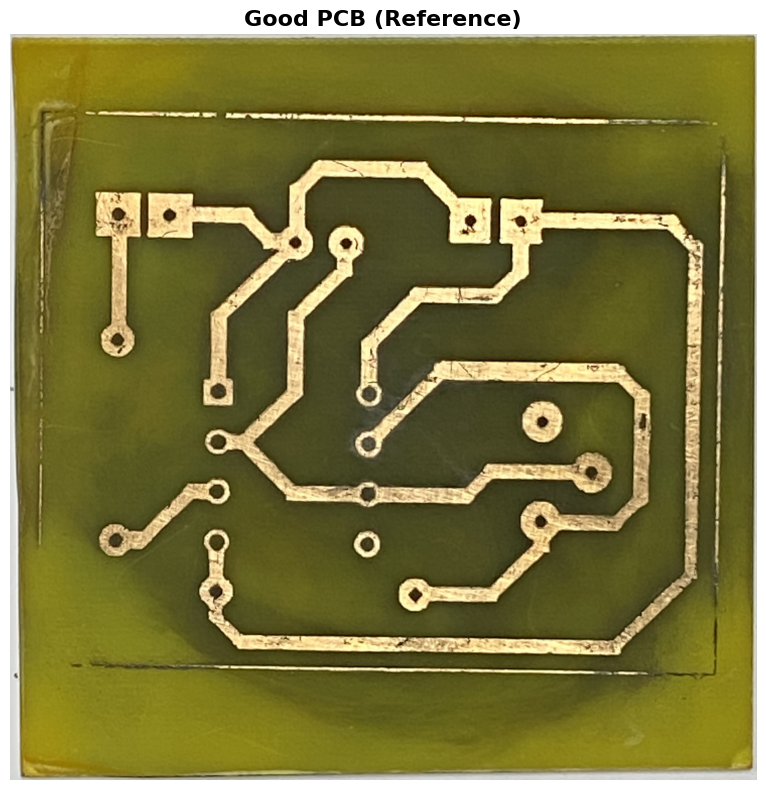

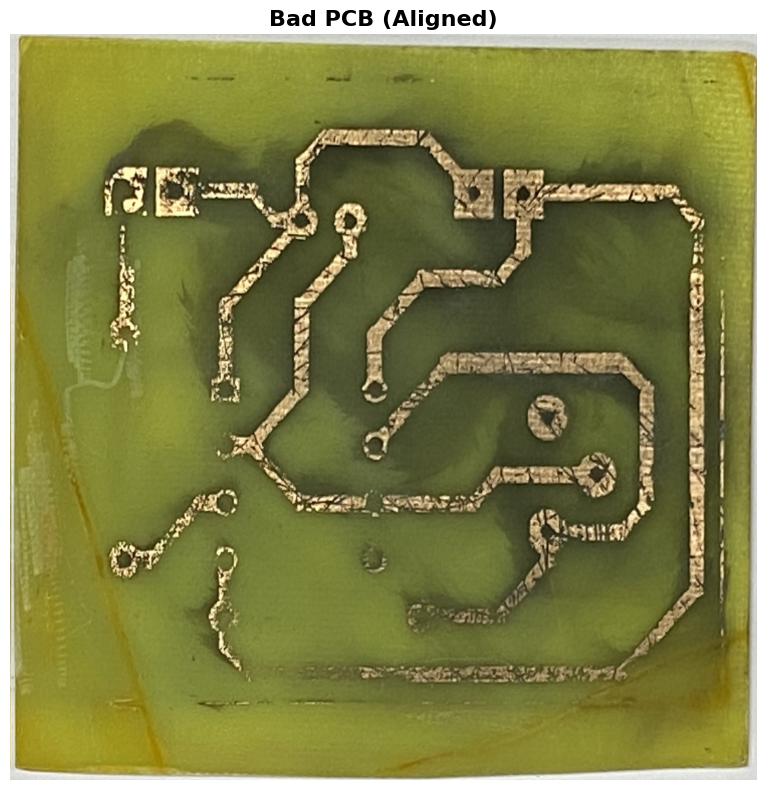

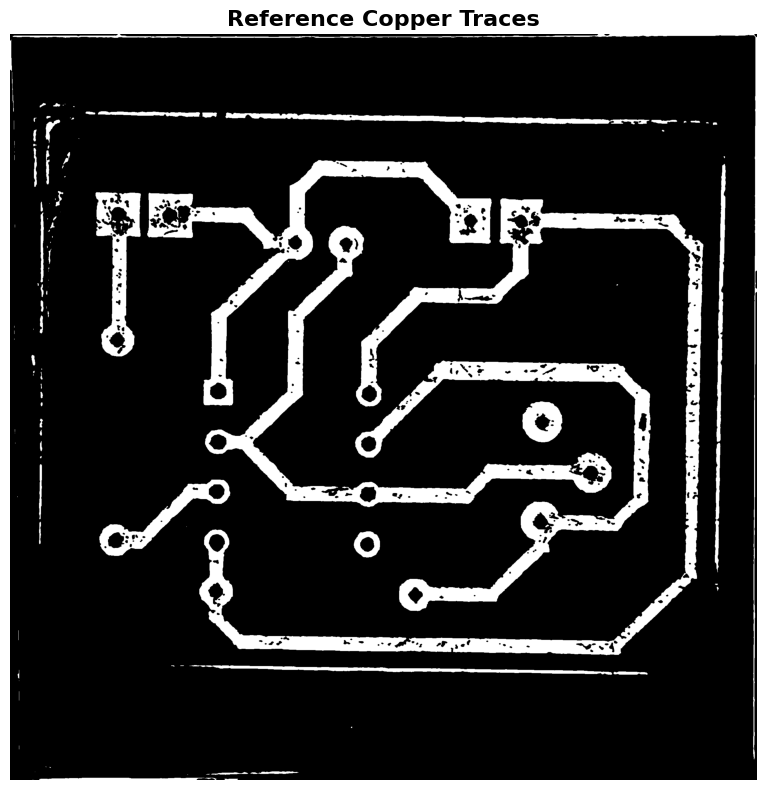

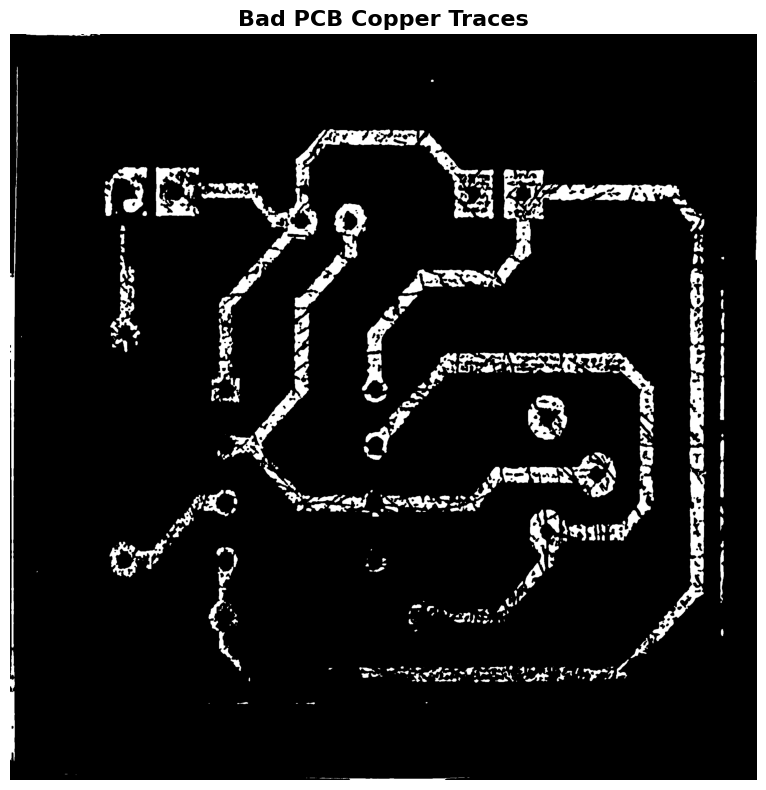

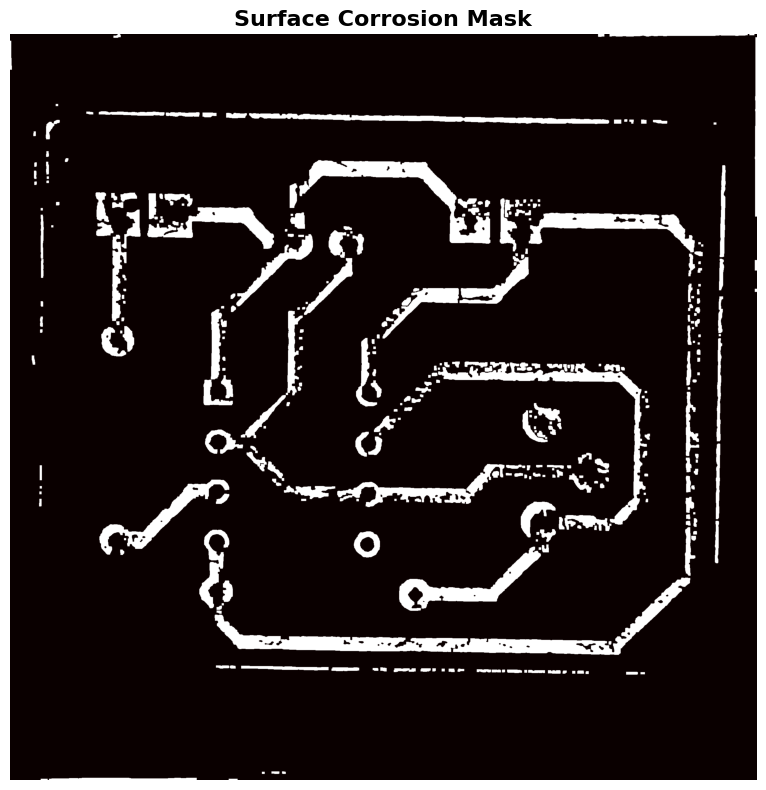

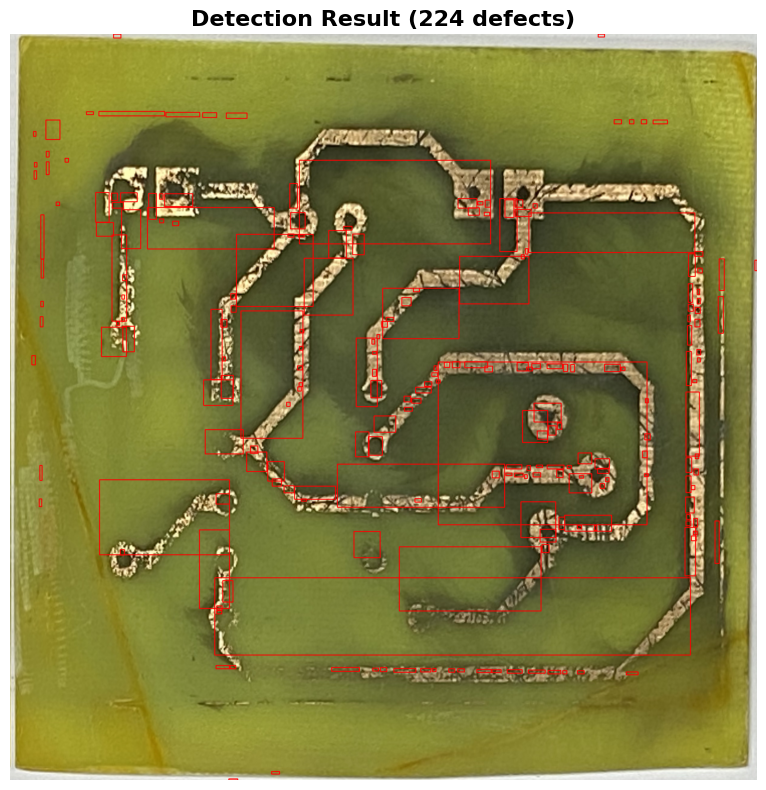


KẾT LUẬN:
- Số vùng ăn mòn được phát hiện: 224
- Tổng số pixel bị ăn mòn: 459865
- Tỷ lệ diện tích ăn mòn so với toàn bộ PCB: 8.41%
- Ăn mòn lan rộng trên bề mặt mạch đồng, cho thấy sự suy giảm rõ rệt so với PCB tham chiếu.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

good_pcb_path = '/content/good_pcb.jpg'
bad_pcb_path = '/content/bad_pcb.jpg'

def crop_pcb_region(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(binary) > 127:
        binary = cv2.bitwise_not(binary)
    kernel = np.ones((15,15), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("Warning: Không tìm thấy contour, trả về ảnh gốc")
        return image
    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    min_area = image.shape[0] * image.shape[1] * 0.1
    if area < min_area:
        print(f"Warning: Contour quá nhỏ ({area:.0f} < {min_area:.0f}), trả về ảnh gốc")
        return image
    x, y, w, h = cv2.boundingRect(largest_contour)
    padding = 5
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(image.shape[1] - x, w + 2*padding)
    h = min(image.shape[0] - y, h + 2*padding)
    cropped = image[y:y+h, x:x+w]
    print(f"  Cropped from {image.shape} to {cropped.shape}")
    return cropped

def align_pcb_orientation(ref_img, target_img):
    ref_gray = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)
    target_resized = cv2.resize(target_img, (ref_img.shape[1], ref_img.shape[0]))
    rotations = [
        (0, target_resized, "0°"),
        (cv2.ROTATE_90_CLOCKWISE, None, "90°"),
        (cv2.ROTATE_180, None, "180°"),
        (cv2.ROTATE_90_COUNTERCLOCKWISE, None, "270°")
    ]
    best_score = float('inf')
    best_rotation = target_resized
    best_angle = "0°"
    print("Trying different orientations...")
    for rotation_code, _, angle_name in rotations:
        if rotation_code == 0:
            rotated = target_resized
        else:
            rotated = cv2.rotate(target_resized, rotation_code)
            if rotated.shape[:2] != ref_img.shape[:2]:
                rotated = cv2.resize(rotated, (ref_img.shape[1], ref_img.shape[0]))
        rotated_gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
        mse = np.mean((ref_gray.astype(float) - rotated_gray.astype(float)) ** 2)
        print(f"  {angle_name}: MSE = {mse:.2f}")
        if mse < best_score:
            best_score = mse
            best_rotation = rotated.copy()
            best_angle = angle_name
    print(f"Best orientation: {best_angle} (MSE = {best_score:.2f})")
    return best_rotation

def refine_translation(ref_img, target_img, ref_mask=None, max_shift=10):
    ref_gray = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)
    tgt_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)
    best_mse = float("inf")
    best_shift = (0, 0)
    h, w = ref_gray.shape
    for dy in range(-max_shift, max_shift + 1):
        for dx in range(-max_shift, max_shift + 1):
            M = np.float32([[1, 0, dx], [0, 1, dy]])
            shifted = cv2.warpAffine(
                tgt_gray, M, (w, h),
                flags=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_REFLECT
            )
            if ref_mask is not None:
                diff = (ref_gray - shifted)[ref_mask == 255]
                mse = np.mean(diff.astype(np.float32) ** 2)
            else:
                mse = np.mean((ref_gray - shifted).astype(np.float32) ** 2)
            if mse < best_mse:
                best_mse = mse
                best_shift = (dx, dy)
    dx, dy = best_shift
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    best_img = cv2.warpAffine(
        target_img, M, (w, h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_REFLECT
    )
    print(f"Best translation: dx={dx}, dy={dy}, MSE={best_mse:.2f}")
    return best_img

def extract_copper_traces(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)
    _, board_mask0 = cv2.threshold(S, 25, 255, cv2.THRESH_BINARY)
    kernel_board = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    board_mask = cv2.morphologyEx(board_mask0, cv2.MORPH_CLOSE, kernel_board, 1)
    board_mask = cv2.morphologyEx(board_mask, cv2.MORPH_OPEN,  kernel_board, 1)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    L_f = L.astype(np.float32)
    bg = cv2.GaussianBlur(L_f, (201, 201), 0)
    ratio = cv2.divide(L_f, bg + 1)
    ratio_n = cv2.normalize(ratio, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, mask_L = cv2.threshold(ratio_n, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if ratio_n[mask_L == 255].mean() < ratio_n[mask_L == 0].mean():
        mask_L = cv2.bitwise_not(mask_L)
    mask_copper0 = cv2.bitwise_and(board_mask, mask_L)
    kernel_copper = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_copper = cv2.morphologyEx(mask_copper0, cv2.MORPH_CLOSE, kernel_copper, 1)
    return mask_copper

def detect_surface_corrosion(ref_copper, bad_copper, ref_img, bad_img):
    valid_copper_region = cv2.bitwise_and(ref_copper, bad_copper)
    kernel = np.ones((5,5), np.uint8)
    valid_copper_region = cv2.erode(valid_copper_region, kernel, iterations=1)
    diff_mask = cv2.absdiff(ref_copper, bad_copper)
    _, missing_copper = cv2.threshold(diff_mask, 50, 255, cv2.THRESH_BINARY)
    missing_copper = cv2.bitwise_and(missing_copper, ref_copper)
    missing_copper = cv2.bitwise_and(missing_copper, cv2.bitwise_not(bad_copper))
    ref_gray = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)
    bad_gray = cv2.cvtColor(bad_img, cv2.COLOR_BGR2GRAY)
    diff_texture = cv2.absdiff(ref_gray, bad_gray)
    _, texture_diff = cv2.threshold(diff_texture, 40, 255, cv2.THRESH_BINARY)
    texture_corrosion = cv2.bitwise_and(texture_diff, valid_copper_region)
    corrosion_mask = cv2.bitwise_or(missing_copper, texture_corrosion)
    kernel = np.ones((3,3), np.uint8)
    corrosion_mask = cv2.morphologyEx(corrosion_mask, cv2.MORPH_OPEN, kernel, iterations=3)
    return corrosion_mask

def find_corrosion_regions(corrosion_mask, min_area=50):
    contours, _ = cv2.findContours(corrosion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bboxes = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > min_area:
            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = max(w, h) / (min(w, h) + 1e-5)
            if aspect_ratio < 15:
                bboxes.append((x, y, w, h))
    return bboxes

def draw_corrosion_boxes(image, bboxes, color=(0, 0, 255), thickness=2):
    result = image.copy()
    for (x, y, w, h) in bboxes:
        cv2.rectangle(result, (x, y), (x+w, y+h), color, thickness)
    return result

print("Loading images...")
good_img = cv2.imread(good_pcb_path)
bad_img = cv2.imread(bad_pcb_path)

print("Cropping PCB regions...")
good_cropped = crop_pcb_region(good_img)
bad_cropped = crop_pcb_region(bad_img)

print("Aligning orientation...")
bad_aligned = align_pcb_orientation(good_cropped, bad_cropped)

if good_cropped.shape != bad_aligned.shape:
    bad_aligned = cv2.resize(bad_aligned, (good_cropped.shape[1], good_cropped.shape[0]))

print("Extracting copper traces...")
ref_copper_mask = extract_copper_traces(good_cropped)

print("Refining translation alignment...")
bad_aligned = refine_translation(
    good_cropped,
    bad_aligned,
    ref_mask=ref_copper_mask,
    max_shift=8
)
bad_copper_mask = extract_copper_traces(bad_aligned)

print("Detecting corrosion...")
surface_corrosion = detect_surface_corrosion(
    ref_copper_mask, bad_copper_mask, good_cropped, bad_aligned
)
kernel = np.ones((3,3), np.uint8)
surface_corrosion = cv2.morphologyEx(surface_corrosion, cv2.MORPH_OPEN, kernel, iterations=1)

print("Finding corrosion regions...")
corrosion_bboxes = find_corrosion_regions(surface_corrosion, min_area=80)
print(f"Found {len(corrosion_bboxes)} corrosion regions")
result_img = draw_corrosion_boxes(bad_aligned, corrosion_bboxes)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(good_cropped, cv2.COLOR_BGR2RGB))
plt.title('Good PCB (Reference)', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(bad_aligned, cv2.COLOR_BGR2RGB))
plt.title('Bad PCB (Aligned)', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.imshow(ref_copper_mask, cmap='gray')
plt.title('Reference Copper Traces', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.imshow(bad_copper_mask, cmap='gray')
plt.title('Bad PCB Copper Traces', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.imshow(surface_corrosion, cmap='hot')
plt.title('Surface Corrosion Mask', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title(f'Detection Result ({len(corrosion_bboxes)} defects)', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

total_area = surface_corrosion.shape[0] * surface_corrosion.shape[1]
corrosion_area = cv2.countNonZero(surface_corrosion)
corrosion_ratio = corrosion_area / total_area * 100

print("\nKẾT LUẬN:")
print(f"- Số vùng ăn mòn được phát hiện: {len(corrosion_bboxes)}")
print(f"- Tổng số pixel bị ăn mòn: {corrosion_area}")
print(f"- Tỷ lệ diện tích ăn mòn so với toàn bộ PCB: {corrosion_ratio:.2f}%")

if len(corrosion_bboxes) == 0:
    print("- Không phát hiện sự khác biệt đáng kể trên bề mặt mạch đồng so với PCB tham chiếu.")
elif corrosion_ratio < 1.0:
    print("- Ăn mòn xuất hiện cục bộ với diện tích nhỏ, chủ yếu là suy giảm bề mặt hoặc trầy xước nhẹ.")
else:
    print("- Ăn mòn lan rộng trên bề mặt mạch đồng, cho thấy sự suy giảm rõ rệt so với PCB tham chiếu.")